# Part 1, Topic 2: Clock Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Similarly to clock glitching, inserting brief glitches into the power line of an embedded device can result in skipped instructions and corrupted results. Besides providing a more reliable glitch on some targets when compared to clock glitching, voltage glitching also has the advanatage that the Vcc pins on chips are always accessable. This won't be covered in this course, but it can also be used to glitch a device asynchronous to its clock.*

**LEARNING OUTCOMES:**

* Understanding voltage glitch settings
* Building a voltage glitch and crash map.
* Modifying glitch circuit to increase glitch success

## Voltage Glitch Hardware

The ChipWhisperer uses the same hardware block for both voltage and clock glitching, with the only difference being where the glitch output is routed to. Instead of routing to HS2, voltage glitching is performed by routing the glitch to either the `glitch_hp` transistor or the `glitch_lp` transistor. This can be done via the following API calls:

```python
scope.io.glitch_hp = True #enable HP glitch
scope.io.glitch_hp = False #disable LP glitch
scope.io.glitch_lp = True #enable LP glitch
scope.io.glitch_lp = False #disable LP glitch
```

While the hardware block are the same, you'll need to change how it's configued. You wouldn't want to try routing `"clock_xor"` to the glitch transistor and oscillate Vcc like the device's clock! Instead, the following two output settings are best suited to voltage glitching:

1. `"glitch_only"` - insert a glitch for a portion of a clock cycle based on `scope.glitch.width` and `scope.glitch.offset`
1. `"enable_only"` - insert a glitch for an entire clock cycle

Typically, the `"enable_only"` setting will be too powerful for most devices. One situation where it outshines `"glitch_only"` is in glitching asychronous to the target's clock. An example of this is glitching a target with an internal clock. In this case, the ChipWhisperer's clock can be boosted far above the target's to insert a precise glitch, with `repeat` functioning as `width` and `ext_offset` functioning as `offset`.

### Voltage Glitching vs. Clock Glitching

Voltage glitching has some obvious benefits over clock glitching, such as working for a wider varitey of targets, but its downsides are less obvious. One of the biggest is how much it depends on the actual glitch circuit itself. With clock glitching, it's relatively easy to insert a glitch - there's nothing external trying to keep the clock at a certain voltage level. This is very different for a target's power pins. When we try to drop the power pin to ground, there's a lot of stuff fighting us to keep the power pin at the correct voltage, such as decoupling capacitors, bulk supply capacitors, and the voltage regulator supplying the voltage. This means when we make small changes to the glitch circuit, the glitch settings and even our ability to insert a glitch at all completely change! Consider glitching a target on the CW308 UFO board. If you switch your coaxial cable length from 20cm to 40 cm, you'll need to find entirely new glitch settings to repeat the attack (if it's still even possible). This is quite easy to see on an oscilloscope or  using the ChipWhisperer's ADC: longer cables and lower valued shunt resistors will make the glitch less sharp and increase ringing.

While your first thought might be to go for as sharp a glitch as possible, this often won't result in a high glitch success rate. Instead, if you're not having much success with glitching, you'll need to experiment with different external setups to find which settings work best for your target. One of the easiest ways to experiment with this is by trying different cable lengths between the ChipWhisperer and the target. If you're using a 1-part ChipWhisperer Lite, this can be done by unsoldering SJ5 and soldering header pins to JP6. Then try connecting different lengths of wire between the two header pins:

You can refer to the training slides for more information about finding good glitch settings, as well as more on the theory side of voltage glitching.

### The Lab

To introduce you to volatge glitching and find some settings, we're going to walk back through the clock glitching loop lab. You may want to capture some power traces while you're first experimenting with glitches to see what effects different glitch widths have on the power trace. Another thing to keep in mind is that targets often won't tolerate the Vcc pin dropping for an extended period of time without crashing - once you see the target start to crash, you won't see much else with larger widths.

You've already run through this lab once, so you'll be mostly on your own. One thing you might have to change is the glitch repeat value. Depending on how wide your glitch is, the voltage at the power pin may not recover by the time the next glitch is inserted. This can have to effect of increasing subsequent glitches' strength, which may or may not be desirable. Since glitches inserted with repeat > 1 have different strength, it's a good idea to scan through ext_offset as well.

###  Higher Frequency Glitching

The XMEGA target, and to a lesser extent the STM32F3, is very difficult to glitch with the default ChipWhisperer settings. Try bumping the clock frequency to 24MHz for the STM32 or 32MHz for the XMEGA and use a repeat 5-10 with both the high power and low power glitches active. You'll need to adjust the baud rate by the same proportion as the clock.

Another setup that seems to work with the XMEGA is SJ5 unsoldered, JP6 jumpered, high+low power glitch, 32MHz, and repeat=5.

In [11]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CW308_STM32F3'

In [12]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-glitch-CW308_STM32F3.hex
rm -f -- simpleserial-glitch-CW308_STM32F3.eep
rm -f -- simpleserial-glitch-CW308_STM32F3.cof
rm -f -- simpleserial-glitch-CW308_STM32F3.elf
rm -f -- simpleserial-glitch-CW308_STM32F3.map
rm -f -- simpleserial-glitch-CW308_STM32F3.sym
rm -f -- simpleserial-glitch-CW308_STM32F3.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-glitch.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-glitch.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-glitch.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch revision 245512]
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying c

In [13]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [14]:
fw_path = "../../../hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5123 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5123 bytes
Serial baud rate = 38400


In [1]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
if PLATFORM == "CWLITEXMEGA":
    scope.clock.clkgen_freq = 32E6
    target.baud = 38400*32/7.37
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.1)
        scope.io.pdic = "high_z"
        time.sleep(0.1)
        #Flush garbage too
        target.flush()
else:
    scope.clock.clkgen_freq = 24E6
    target.baud = 38400*24/7.37
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = True
        time.sleep(0.05)
        #Flush garbage too
        target.flush()
        
# ###################
# END SOLUTION
# ###################

NameError: name 'PLATFORM' is not defined

In [34]:
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
reboot_flush()
target.write("g\n")
scope.capture()
val = target.simpleserial_read_witherrors('r', 4)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)
# ###################
# END SOLUTION
# ###################

{'valid': True, 'payload': CWbytearray(b'c3 09 00 00'), 'full_response': 'rC3090000\n', 'rv': 1}


In [7]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset", "ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

In [28]:
#Basic setup
# ###################
# Add your code here
# ###################
#raise NotImplementedError("Add your code here, and delete this.")

# ###################
# START SOLUTION
# ###################
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
if PLATFORM == "CWLITEXMEGA":
    scope.io.glitch_lp = True
    scope.io.glitch_hp = True
elif PLATFORM == "CWLITEARM":
    scope.io.glitch_lp = True
    scope.io.glitch_hp = True
elif PLATFORM == "CW308_STM32F3":
    scope.io.glitch_hp = True
    scope.io.glitch_lp = True
    
# ###################
# END SOLUTION
# ###################

In [33]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct
scope.glitch.ext_offset = 13

scope.glitch.width_fine = 0
scope.glitch.offset_fine = 0

g_step = 0.4
if PLATFORM=="CWLITEXMEGA":
    gc.set_range("width", 45.7, 47.8)
    gc.set_range("offset", 2.8, 10)
    gc.set_range("ext_offset", 2, 4)
    scope.glitch.repeat = 10
elif PLATFORM == "CWLITEARM":
    gc.set_range("width", 36.7, 40)
    gc.set_range("offset", -47.8, -40)
    gc.set_range("ext_offset", 6, 15)
    scope.glitch.repeat = 5
elif PLATFORM == "CW308_STM32F3":
    gc.set_range("width", 47.2, 50)
    gc.set_range("offset", -48.65, -47.65)
    gc.set_range("ext_offset", 8, 8)
    scope.glitch.repeat = 3
#gc.set_range("offset", -20.3/div, -19.2/div)

gc.set_global_step(g_step)


scope.adc.timeout = 0.1

reboot_flush()
sample_size = 1
loff = scope.glitch.offset
lwid = scope.glitch.width

for glitch_setting in gc.glitch_values():
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]
    scope.glitch.ext_offset = glitch_setting[2]
    #print(scope.glitch.ext_offset)
    succ = 0
    res = 0
    for i in range(100):
        target.flush()
        if scope.adc.state:
            # can detect crash here (fast) before timing out (slow)
            print("Trigger still high!")
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            #plt.plot(lwid, loff, 'xr', alpha=1)
            #fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
            res += 1
            
        scope.arm()
        
        #Do glitch loop
        target.write("g\n")
        
        ret = scope.capture()
        
        
        val = target.simpleserial_read_witherrors('r', 4)#For loop check
        loff = scope.glitch.offset
        lwid = scope.glitch.width
        scope.io.glitch_hp = False
        scope.io.glitch_hp = True
        scope.io.glitch_lp = False
        scope.io.glitch_lp = True
        if ret:
            print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            #plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
            #fig.canvas.draw()
            res += 1

            #Device is slow to boot?
            reboot_flush()

        else:
            if val['valid'] is False:
                #print("Invalid response: ", val['full_response'])
                gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                reboot_flush()
                #plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
                #fig.canvas.draw()
                res += 1
            else:
                gcnt = struct.unpack("<I", val['payload'])[0]

                #print(gcnt)                
                # for table display purposes
                #if gnt != 0: #for code-flow check
                if gcnt != 2500: #for loop check
                    gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    #plt.plot(scope.glitch.width, scope.glitch.offset, '+g')
                    #fig.canvas.draw()
                    #print("🐙", end="")
                    #print(val['payload'])
                    #print(scope.glitch.width, scope.glitch.offset)
                    succ += 1
                else:
                    gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    #plt.plot(scope.glitch.width, scope.glitch.offset, '.k', alpha=0.1)
                   # fig.canvas.draw()
    if succ > 0:                
        print("successes = {}, resets = {}, offset = {}, width = {}, ext_offset = {}".format(succ, res, scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset))
print("Done glitching")

successes = 11, resets = 0, offset = -48.828125, width = 47.65625, ext_offset = 8


successes = 18, resets = 0, offset = -48.4375, width = 47.65625, ext_offset = 8


successes = 12, resets = 1, offset = -47.65625, width = 47.65625, ext_offset = 8


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


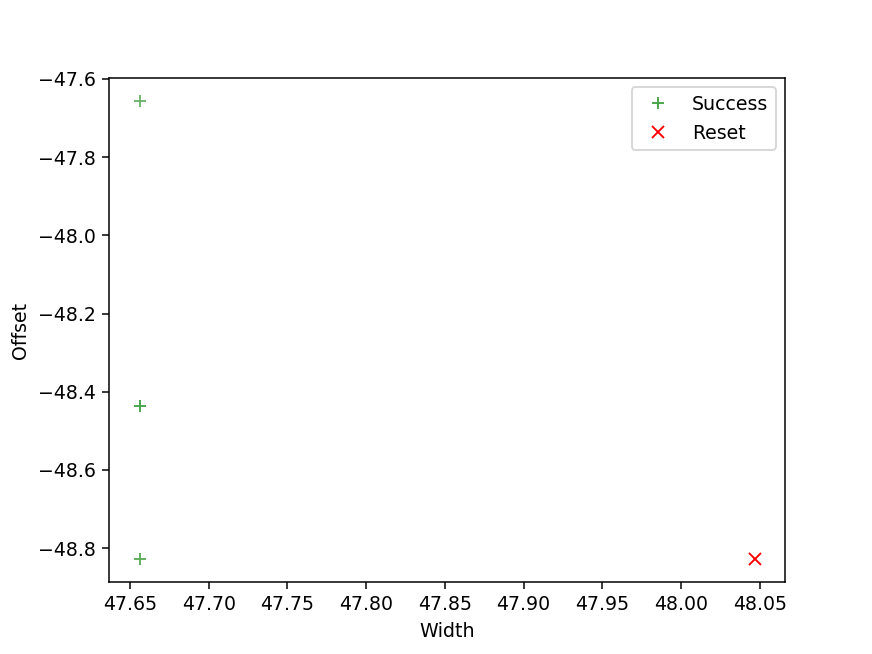

In [31]:
%matplotlib notebook
gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None})